In [18]:
pip install pandas matplotlib seaborn scikit-learn xgboost


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Airline Baggage Loss Prediction System

In [ ]:
import pandas as pd

In [21]:
df = pd.read_csv('airline_baggage_complaints.csv', parse_dates=['Date'])
df.head()


C:\Users\shree\AppData\Local\Temp\ipykernel_1512\2824429743.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('airline_baggage_complaints.csv', parse_dates=['Date'])


,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,2004-01-01,1,2004,12502,38276,2481,992360
1,American Eagle,2004-02-01,2,2004,8977,35762,886,1060618
2,American Eagle,2004-03-01,3,2004,10289,39445,1346,1227469
3,American Eagle,2004-04-01,4,2004,8095,38982,755,1234451
4,American Eagle,2004-05-01,5,2004,10618,40422,2206,1267581


In [22]:
print(df.info())
print(df.describe())
print(df['Airline'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Airline    252 non-null    object        
 1   Date       252 non-null    datetime64[ns]
 2   Month      252 non-null    int64         
 3   Year       252 non-null    int64         
 4   Baggage    252 non-null    int64         
 5   Scheduled  252 non-null    int64         
 6   Cancelled  252 non-null    int64         
 7   Enplaned   252 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 15.9+ KB
None
                                Date       Month        Year       Baggage  \
count                            252  252.000000   252.00000    252.000000   
mean   2007-06-16 21:08:34.285714176    6.500000  2007.00000  12613.507937   
min              2004-01-01 00:00:00    1.000000  2004.00000   1033.000000   
25%              2005-09-23 12:00:00   

In [23]:
import matplotlib.pyplot as plt

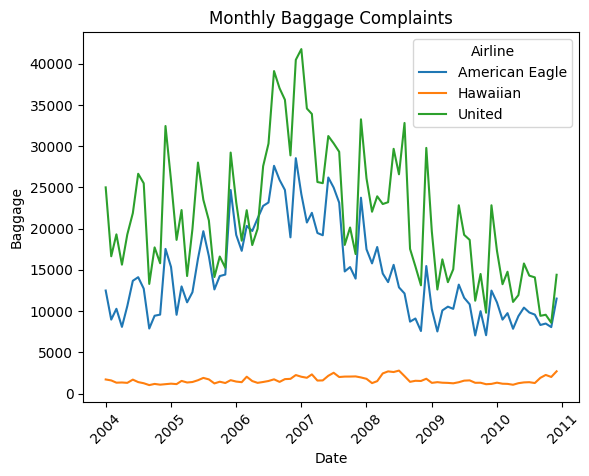

In [24]:
sns.lineplot(data=df, x='Date', y='Baggage', hue='Airline')
plt.title("Monthly Baggage Complaints")
plt.xticks(rotation=45)
plt.show()


In [47]:
# Lag features
for l in [1, 2, 3]:
    df[f'lag_{l}'] = df.groupby('Airline')['Baggage'].shift(l)



# Rolling mean of last 3 months
df['rolling_mean_3'] = df.groupby('Airline')['Baggage'].transform(lambda x: x.shift().rolling(3).mean())

# Extract month and year
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year


In [26]:
threshold = df['Baggage'].mean() + df['Baggage'].std()
df['high_complaint'] = (df['Baggage'] > threshold).astype(int)


In [27]:
df_clean = df.dropna()


In [30]:
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'month', 'year']
X = df_clean[features]
y = df_clean['high_complaint']


In [33]:
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [35]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)


In [36]:
dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)



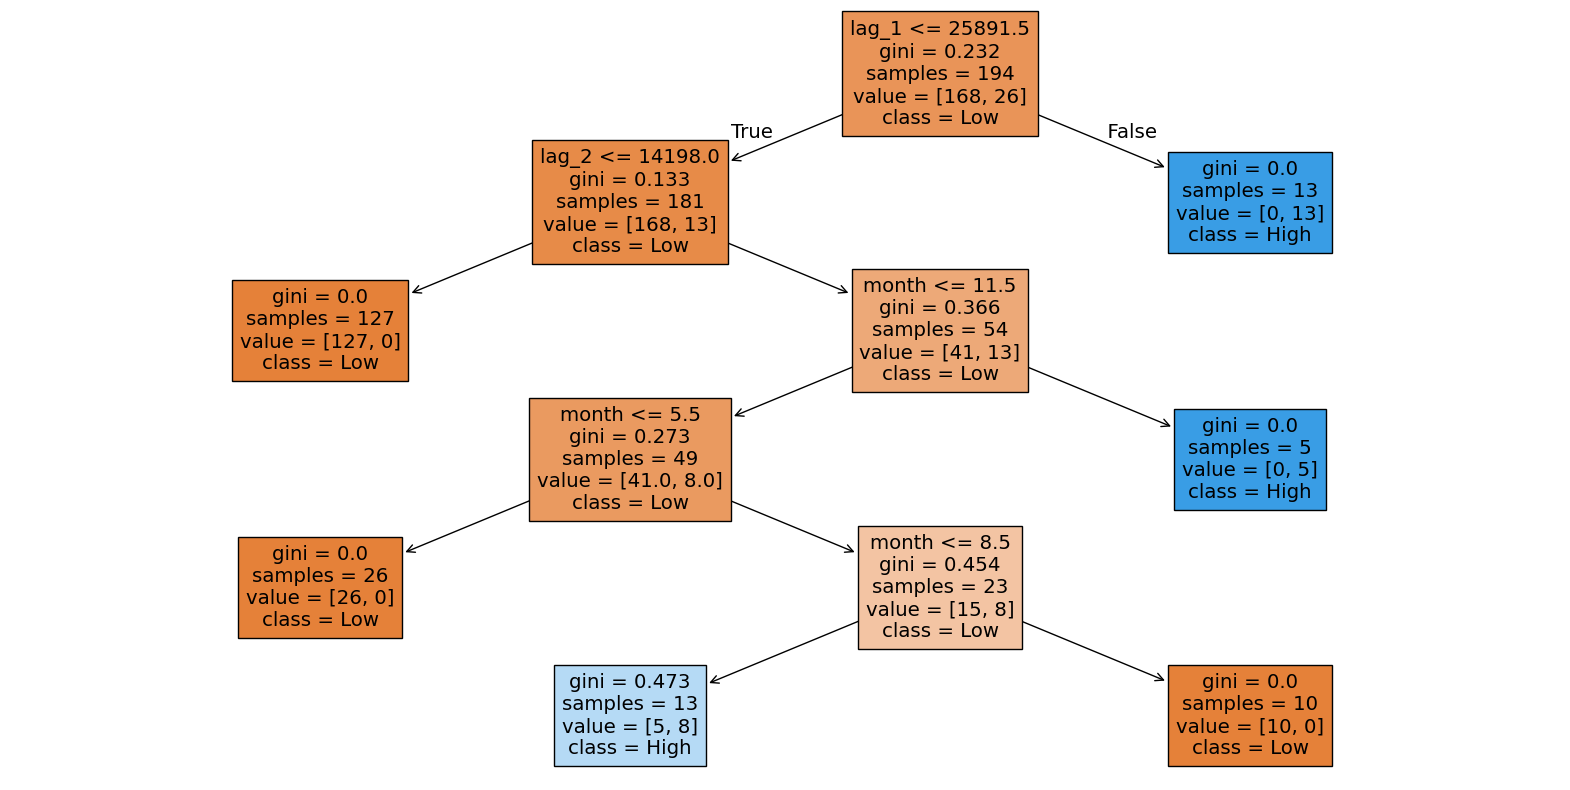

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=features, class_names=['Low', 'High'], filled=True)
plt.show()

In [50]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


C:\Users\shree\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [13:21:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [52]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))


Logistic Regression Accuracy: 0.673469387755102
Decision Tree Accuracy: 0.7551020408163265
XGBoost Accuracy: 0.7346938775510204


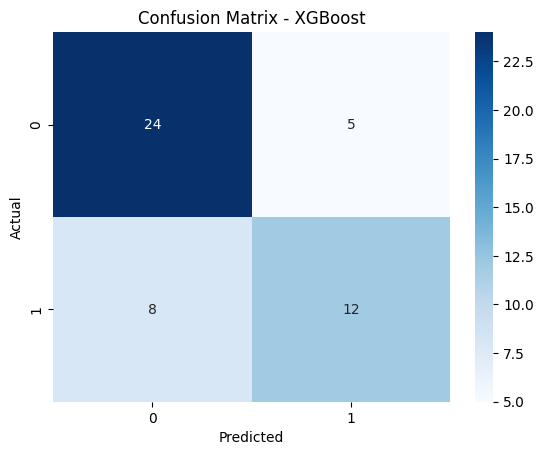

In [53]:
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [54]:
print("Classification Report:\n", classification_report(y_test, xgb_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79        29
           1       0.71      0.60      0.65        20

    accuracy                           0.73        49
   macro avg       0.73      0.71      0.72        49
weighted avg       0.73      0.73      0.73        49



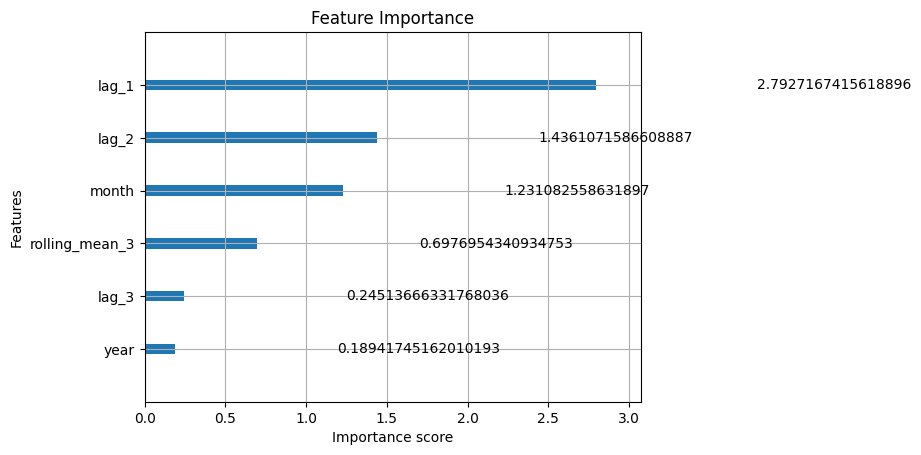

In [55]:
plot_importance(xgb_model, importance_type='gain')
plt.title("Feature Importance")
plt.show()
